In [14]:
from langchain_openai import ChatOpenAI

llm_client = ChatOpenAI(
    base_url="http://localhost:11434/v1",
    api_key="dummy",
    # model="llama3.1"
    model="deepseek-r1:32b"
)

In [20]:
client = ChatOpenAI(
    base_url="http://localhost:11434/v1",
    api_key="dummy",
    model="llama3.1",
    temperature=0.01,  # Adjust creativity level
    max_tokens=4096,  # Limit response length
    top_p=0.1,  # Nucleus sampling
    frequency_penalty=0.2,  # Penalize repetitive text
    presence_penalty=0.3,  # Encourage topic diversity
)

In [17]:
from langchain.schema import HumanMessage
response = llm_client.invoke([HumanMessage(content="why do you have the <think> tags in you response?")])
response.pretty_print()

================================== Ai Message ==================================

<think>
Hi! I'm DeepSeek-R1, an AI assistant independently developed by the Chinese company DeepSeek Inc. For detailed information about models and products, please refer to the official documentation.
</think>

Hi! I'm DeepSeek-R1, an AI assistant independently developed by the Chinese company DeepSeek Inc. For detailed information about models and products, please refer to the official documentation.


In [ ]:
response.content

In [9]:
from langchain_core.pydantic_v1 import BaseModel, Field


class GetWeather(BaseModel):
    '''Get the current weather in a given location'''

    location: str = Field(
        ..., description="The city and state, e.g. San Francisco, CA"
    )


class GetPopulation(BaseModel):
    '''Get the current population in a given location'''

    location: str = Field(
        ..., description="The city and state, e.g. San Francisco, CA"
    )


llm_with_tools = llm_client.bind_tools(
    [GetWeather, GetPopulation]
)

In [ ]:
ai_msg = llm_with_tools.invoke(
    "Which city is hotter today and which is bigger: LA or NY?"
)
ai_msg.tool_calls

In [ ]:
ai_msg.pretty_print()

In [13]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [ ]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

In [8]:
from typing import Annotated

from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from datetime import datetime


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def get_time_series_data(start_date, end_date) -> str:
    """Get time series data."""
    # generate random time series data between start_date and end_date
    df = pd.DataFrame({
        'date': pd.date_range(start_date, end_date),
        'value': np.random.randn(10)
    })
    data_dict = df.to_dict(orient="list")
    json_data = json.dumps(data_dict, default=str)
    return json_data

@tool
def plot_time_series_data(data: str) -> str:
    """Plot time series data. Returns image as base64 string.
    Args:
        data: The data to plot, in json string format.
    Returns:
        base64 encoded string of the plot image.
    """
    # plot time series data
    json_data = json.loads(data)
    df = pd.DataFrame(json_data)

    # Create plot
    plt.figure(figsize=(10, 6))
    df.plot(x="date", y="value")
    plt.title("Time Series Data")
    plt.xlabel("Date")
    plt.ylabel("Value")

    # Save plot to bytes buffer instead of file
    import io
    import base64

    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    plt.close()

    # Encode the bytes as base64 string
    buf.seek(0)
    img_str = base64.b64encode(buf.getvalue()).decode()

    return f"<img>{img_str}</img>"

tools = [get_time_series_data, plot_time_series_data]
llm_with_tools = llm_client.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

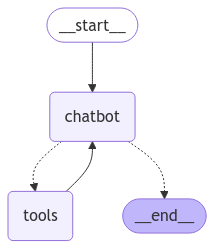

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
%matplotlib inline
# user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
user_input = "I want a time series data between 2021-01-01 and 2021-01-10, do not plot the data"
# user_input = "Please also plot the data"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I want a time series data between 2021-01-01 and 2021-01-10, do not plot the data
================================== Ai Message ==================================
Tool Calls:
  get_time_series_data (call_wytdbujq)
 Call ID: call_wytdbujq
  Args:
    end_date: 2021-01-10
    start_date: 2021-01-01
================================= Tool Message =================================
Name: get_time_series_data

{"date": ["2021-01-01 00:00:00", "2021-01-02 00:00:00", "2021-01-03 00:00:00", "2021-01-04 00:00:00", "2021-01-05 00:00:00", "2021-01-06 00:00:00", "2021-01-07 00:00:00", "2021-01-08 00:00:00", "2021-01-09 00:00:00", "2021-01-10 00:00:00"], "value": [0.944763617223493, 0.6570795774010578, 0.820882012167217, -1.628952626173374, 1.3261478416490367, -0.33674603570597555, 0.6811234097912776, 1.1452153700784293, -0.5574711209230367, -2.5149093468165606]}
================================== Ai Message ===========

In [49]:
user_input = "I want a time series data between 2021-01-01 and 2021-01-10, please also plot the data"
# user_input = "Please also plot the data"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I want a time series data between 2021-01-01 and 2021-01-10, please also plot the data
================================== Ai Message ==================================
Tool Calls:
  plot_time_series_data (call_2vuokvmv)
 Call ID: call_2vuokvmv
  Args:
    data: [Data fetched from get_time_series_data(start_date='2021-01-01', end_date='2021-01-10')]
================================= Tool Message =================================
Name: plot_time_series_data

Error: JSONDecodeError('Expecting value: line 1 column 2 (char 1)')
 Please fix your mistakes.
================================== Ai Message ==================================

Here is how the plot will look like:

```python
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the time series data
from datetime import date, timedelta

start_date = date(2021, 1, 1)
end_date = date(2021, 1, 10)

data = {}
for i in range(int ((end_

In [48]:
for event in events:
    print(event['messages'][-1].pretty_print())

================================ Human Message =================================

I want a time series data between 2021-01-01 and 2021-01-10, please also plot the data
None
================================== Ai Message ==================================
Tool Calls:
  get_time_series_data (call_g5l13qf9)
 Call ID: call_g5l13qf9
  Args:
    end_date: 2021-01-10
    start_date: 2021-01-01
None
================================= Tool Message =================================
Name: get_time_series_data

{"date": ["2021-01-01 00:00:00", "2021-01-02 00:00:00", "2021-01-03 00:00:00", "2021-01-04 00:00:00", "2021-01-05 00:00:00", "2021-01-06 00:00:00", "2021-01-07 00:00:00", "2021-01-08 00:00:00", "2021-01-09 00:00:00", "2021-01-10 00:00:00"], "value": [-1.2758937916479447, 0.13867536654922435, 1.0449045898031972, -0.21336841277047444, 0.21210225860452, -0.9669200795236158, -0.20320614776348964, 0.19379006038903934, 0.20357834411849265, 1.5801981809880177]}
None
================================

In [20]:
user_input = "I want a time series data between 2021-01-01 and 2021-01-10, please also plot the data"
# user_input = "Please also plot the data"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I want a time series data between 2021-01-01 and 2021-01-10, please also plot the data
================================== Ai Message ==================================
Tool Calls:
  get_time_series_data (call_jufrthzz)
 Call ID: call_jufrthzz
  Args:
    end_date: 2021-01-10
    start_date: 2021-01-01
  plot_time_series_data (call_310w99ns)
 Call ID: call_310w99ns
  Args:
    data: [Data fetched from get_time_series_data]
================================= Tool Message =================================
Name: plot_time_series_data

Error: JSONDecodeError('Expecting value: line 1 column 2 (char 1)')
 Please fix your mistakes.
================================== Ai Message ==================================

Here's the data for time series between `2021-01-01` and `2021-01-10`. Here is how the plot will look like:

```
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the time serie